# SARSA CartPole

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import time
import random
from itertools import product


GAMMA = 0.99

# SARSA hyperparameters
N_EPISODES = 500
MAX_STEPS = 500
ALPHA = 0.1
EPS_START = 1.0
EPS_END = 0.05

SEED_LIST = list(range(1, 3))  # seeds
BASE_B = 3                     

print("Seed list:", SEED_LIST)
print("Base grid size:", BASE_B)


Seed list: [1, 2]
Base grid size: 3


In [3]:

# ------------------------------
# Helpers: seeding, discretization
# ------------------------------
def set_seed(seed: int):
    np.random.seed(seed)
    random.seed(seed)

TERMINAL = (-1, -1, -1, -1)

def make_n_bins(b: int):
    """Map scalar grid size to per-dimension bins (same pattern as VI/PI)."""
    return [b, b, 2 * b, 2 * b]

def build_states(n_bins_vec):
    states = list(product(*(range(n) for n in n_bins_vec)))
    states.append(TERMINAL)
    return states

def get_cartpole_bounds(env):
    low = env.observation_space.low.astype(np.float64).copy()
    high = env.observation_space.high.astype(np.float64).copy()
    # Cap unbounded dimensions
    low[1] = -3.0
    high[1] = 3.0
    low[3] = -3.0
    high[3] = 3.0
    return low, high

def discretize_state(obs, n_bins_vec, state_low, state_high):
    ratios = (obs - state_low) / (state_high - state_low)
    ratios = np.clip(ratios, 0.0, 0.9999)
    bins = [int(r * n) for r, n in zip(ratios, n_bins_vec)]
    return tuple(bins)

# ------------------------------
# SARSA algorithm
# ------------------------------
def epsilon_greedy(Q, state_idx, eps, n_actions=2):
    if np.random.rand() < eps:
        return np.random.randint(n_actions)
    else:
        return int(np.argmax(Q[state_idx]))

def sarsa_train(env,
                n_bins_vec,
                state_low,
                state_high,
                states,
                state_to_idx,
                n_episodes=N_EPISODES,
                max_steps=MAX_STEPS,
                alpha=ALPHA,
                gamma=GAMMA,
                eps_start=EPS_START,
                eps_end=EPS_END):
    """
    Tabular SARSA on discretized CartPole.
    Returns:
        Q:      (n_states, n_actions)
        returns_per_episode: length n_episodes
        deltaQ_per_episode:  length n_episodes (max |ΔQ| in that episode)
    """
    n_actions = 2
    n_states = len(state_to_idx)
    Q = np.zeros((n_states, n_actions), dtype=np.float64)

    returns = np.zeros(n_episodes, dtype=np.float64)
    delta_Q = np.zeros(n_episodes, dtype=np.float64)

    for ep in range(n_episodes):
        # Linear epsilon decay
        frac = ep / max(1, n_episodes - 1)
        eps = eps_start + frac * (eps_end - eps_start)

        obs, _ = env.reset()
        s = discretize_state(obs, n_bins_vec, state_low, state_high)
        s_idx = state_to_idx[s]

        a = epsilon_greedy(Q, s_idx, eps, n_actions=n_actions)

        total_r = 0.0
        max_delta_this_ep = 0.0

        for t in range(max_steps):
            next_obs, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            total_r += r

            if done:
                target = r  # no next Q term
                s_next_idx = None
                a_next = None
            else:
                s_next = discretize_state(next_obs, n_bins_vec, state_low, state_high)
                s_next_idx = state_to_idx[s_next]
                a_next = epsilon_greedy(Q, s_next_idx, eps, n_actions=n_actions)
                target = r + gamma * Q[s_next_idx, a_next]

            old_q = Q[s_idx, a]
            Q[s_idx, a] = old_q + alpha * (target - old_q)
            delta = abs(Q[s_idx, a] - old_q)
            if delta > max_delta_this_ep:
                max_delta_this_ep = delta

            if done:
                break

            # move on
            obs = next_obs
            s_idx = s_next_idx
            a = a_next

        returns[ep] = total_r
        delta_Q[ep] = max_delta_this_ep

    return Q, returns, delta_Q

# ------------------------------
# Evaluation helper (greedy policy)
# ------------------------------
def q_to_policy(Q, states, state_to_idx):
    policy = {}
    for s in states:
        if s == TERMINAL:
            continue
        idx = state_to_idx[s]
        policy[s] = int(np.argmax(Q[idx]))
    return policy

def evaluate_policy(env,
                    policy,
                    n_bins_vec,
                    state_low,
                    state_high,
                    n_episodes=50,
                    max_steps=MAX_STEPS):
    returns = []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_r = 0.0
        steps = 0
        while not done and steps < max_steps:
            s = discretize_state(obs, n_bins_vec, state_low, state_high)
            a = policy.get(s, 0)
            obs, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            total_r += r
            steps += 1
        returns.append(total_r)
    return np.array(returns, dtype=np.float64)

# ------------------------------
# Plot helpers
# ------------------------------
def plot_mean_iqr(curves, title, ylabel, filename,
                  x_label="Episode", ylog=False):
    """
    curves: list of 1D arrays, one per seed.
    Plots mean with IQR band.
    """
    if len(curves) == 0:
        return

    max_len = max(len(c) for c in curves)
    mat = np.full((len(curves), max_len), np.nan)
    for i, c in enumerate(curves):
        mat[i, :len(c)] = c

    mean = np.nanmean(mat, axis=0)
    q25 = np.nanpercentile(mat, 25, axis=0)
    q75 = np.nanpercentile(mat, 75, axis=0)
    xs = np.arange(max_len)

    plt.figure(figsize=(6, 4))
    plt.plot(xs, mean, label="mean")
    plt.fill_between(xs, q25, q75, alpha=0.3, label="IQR")
    if ylog:
        plt.yscale("log")
    plt.xlabel(x_label)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

def plot_mean_std_over_seeds(returns_per_seed, title, filename):
    """
    returns_per_seed: list of 1D arrays (n_episodes),
    Build mean ± std across seeds at each episode.
    """
    if len(returns_per_seed) == 0:
        return

    max_len = max(len(c) for c in returns_per_seed)
    mat = np.full((len(returns_per_seed), max_len), np.nan)
    for i, c in enumerate(returns_per_seed):
        mat[i, :len(c)] = c

    mean = np.nanmean(mat, axis=0)
    std = np.nanstd(mat, axis=0)
    xs = np.arange(max_len)

    plt.figure(figsize=(6, 4))
    plt.plot(xs, mean, label="mean return")
    plt.fill_between(xs, mean - std, mean + std, alpha=0.3, label="±1 std")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title(title)
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# ------------------------------
# Main experiment
# ------------------------------



Running SARSA for seed 1
Running SARSA for seed 2

Total SARSA wall-clock over all seeds: 1.50 s


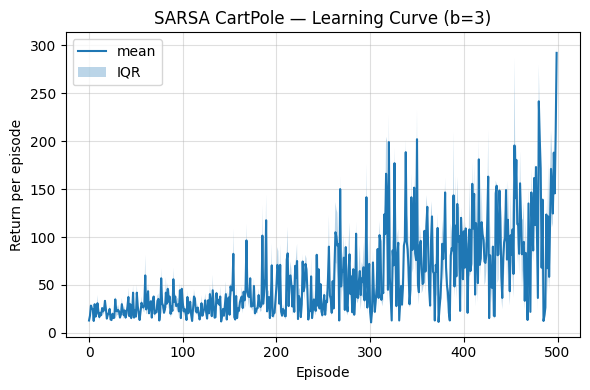

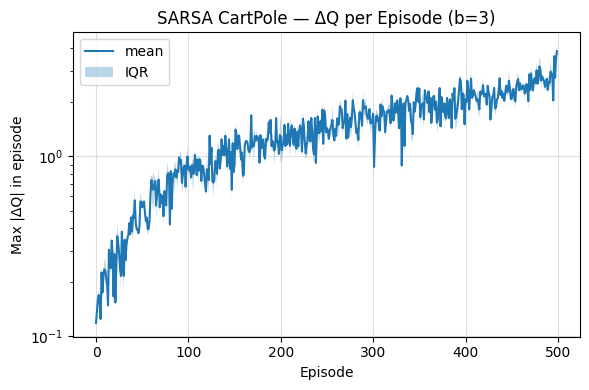

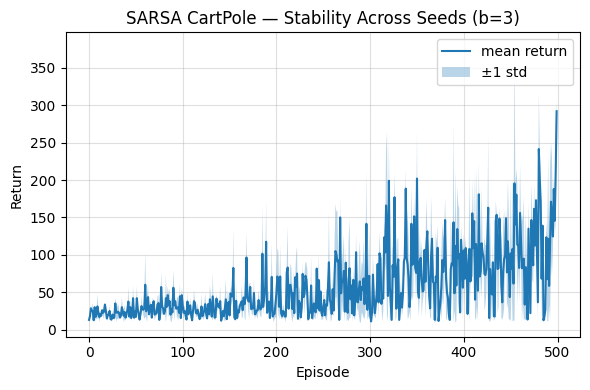


Evaluation returns (greedy policy) per seed:
  Seed 1: mean return = 173.08
  Seed 2: mean return = 167.86
Overall mean ± std: 170.47 ± 2.61


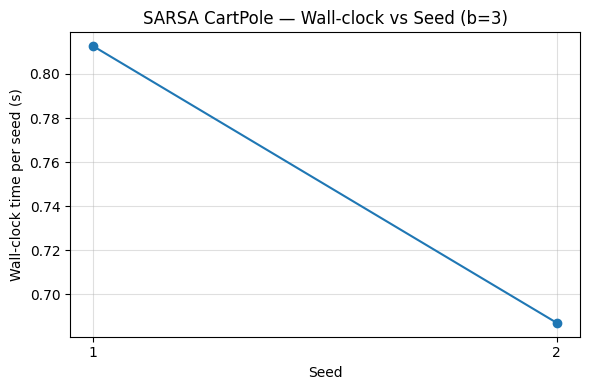


Done. SARSA CartPole figures saved as:
  - cartpole_sarsa_learning_curve_b3.pdf
  - cartpole_sarsa_deltaQ_b3.pdf
  - cartpole_sarsa_stability_b3.pdf
  - cartpole_sarsa_wallclock_vs_seed_b3.pdf


In [4]:
actions = [0, 1]
b = BASE_B
n_bins_vec = make_n_bins(b)
states = build_states(n_bins_vec)

# mapping from state -> index (exclude TERMINAL from Q)
state_to_idx = {s: i for i, s in enumerate(states) if s != TERMINAL}

all_returns = []      # list of (N_EPISODES,) per seed
all_deltaQ = []       # list of (N_EPISODES,) per seed
eval_returns = []     # scalar mean eval return per seed
wallclock_per_seed = []

total_wallclock = 0.0

for seed in SEED_LIST:
    print(f"Running SARSA for seed {seed}")
    set_seed(seed)
    env = gym.make("CartPole-v1")

    state_low, state_high = get_cartpole_bounds(env)

    t0 = time.time()
    Q, returns_ep, deltaQ_ep = sarsa_train(
        env,
        n_bins_vec,
        state_low,
        state_high,
        states,
        state_to_idx,
        n_episodes=N_EPISODES,
        max_steps=MAX_STEPS,
        alpha=ALPHA,
        gamma=GAMMA,
        eps_start=EPS_START,
        eps_end=EPS_END,
    )
    elapsed = time.time() - t0
    total_wallclock += elapsed
    wallclock_per_seed.append(elapsed)

    all_returns.append(returns_ep)
    all_deltaQ.append(deltaQ_ep)

    # Evaluate final greedy policy (optional, useful for checking stability)
    policy = q_to_policy(Q, states, state_to_idx)
    eval_ret = evaluate_policy(
        env,
        policy,
        n_bins_vec,
        state_low,
        state_high,
        n_episodes=50,
        max_steps=MAX_STEPS,
    )
    eval_returns.append(eval_ret.mean())

    env.close()

print(f"\nTotal SARSA wall-clock over all seeds: {total_wallclock:.2f} s")

# ------------------------------
# 1) Learning curve: return vs episodes
# ------------------------------
plot_mean_iqr(
    all_returns,
    title=f"SARSA CartPole — Learning Curve (b={b})",
    ylabel="Return per episode",
    filename=f"cartpole_sarsa_learning_curve_b{b}.pdf",
    x_label="Episode",
    ylog=False,
)

# ------------------------------
# 2) ΔQ vs episodes (max Q-table change)
# ------------------------------
plot_mean_iqr(
    all_deltaQ,
    title=f"SARSA CartPole — ΔQ per Episode (b={b})",
    ylabel="Max |ΔQ| in episode",
    filename=f"cartpole_sarsa_deltaQ_b{b}.pdf",
    x_label="Episode",
    ylog=True,  # often nice to see convergence on log scale
)

# ------------------------------
# 3) Stability plot: mean ± std of return across seeds
#    (here: return vs episodes with band = std across seeds)
# ------------------------------
plot_mean_std_over_seeds(
    all_returns,
    title=f"SARSA CartPole — Stability Across Seeds (b={b})",
    filename=f"cartpole_sarsa_stability_b{b}.pdf",
)

# If you also want a single-point stability summary (final performance):
eval_returns = np.array(eval_returns, dtype=np.float64)
print("\nEvaluation returns (greedy policy) per seed:")
for seed, r in zip(SEED_LIST, eval_returns):
    print(f"  Seed {seed}: mean return = {r:.2f}")
print(f"Overall mean ± std: {eval_returns.mean():.2f} ± {eval_returns.std():.2f}")

# ------------------------------
# 4) Wall-clock time vs seed
# ------------------------------
plt.figure(figsize=(6, 4))
plt.plot(SEED_LIST, wallclock_per_seed, "-o")
plt.xlabel("Seed")
plt.ylabel("Wall-clock time per seed (s)")
plt.title(f"SARSA CartPole — Wall-clock vs Seed (b={b})")
plt.grid(True, alpha=0.4)
plt.xticks(SEED_LIST)
plt.tight_layout()
plt.savefig(f"cartpole_sarsa_wallclock_vs_seed_b{b}.pdf")
plt.show()

print("\nDone. SARSA CartPole figures saved as:")
print(f"  - cartpole_sarsa_learning_curve_b{b}.pdf")
print(f"  - cartpole_sarsa_deltaQ_b{b}.pdf")
print(f"  - cartpole_sarsa_stability_b{b}.pdf")
print(f"  - cartpole_sarsa_wallclock_vs_seed_b{b}.pdf")